In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0,'../utils')
from util import *

In [2]:
milc_runs = pd.read_csv('/home/jovyan/work/hpc_networks/data/app_runs/mutrino_milc_runs.csv')

In [3]:
OUTPUT_CSVS = [\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_0_4_c.1580565680',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_1_4_c.1580565680',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_2_4_c.1580565680',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_3_4_c.1580565680',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_1_4_s.1580565680',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_2_4_s.1580565680']

OUTPUT_CSV_HEADERS = [\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_0_4_c.1580565680.HEADER',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_1_4_c.1580565680.HEADER',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_2_4_c.1580565680.HEADER',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_3_4_c.1580565680.HEADER',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_1_4_s.1580565680.HEADER',\
'/home/jovyan/work/hpc_networks/data/processed_mutrino/metric_set_rtr_2_4_s.1580565680.HEADER']

df = pd.DataFrame()
for (output_csv,output_csv_header) in zip(OUTPUT_CSVS,OUTPUT_CSV_HEADERS):
    df = df.append(pd.read_csv(output_csv,header=None,names = open(output_csv_header).readlines()[0].split(',')))


In [4]:
topology_graph = create_networkx_graph('/home/jovyan/work/hpc_networks/data/system_maps/mutrino_rtr.out')

In [47]:
df['delay'] = df['stall'].apply(lambda x : 4e9/(4e9-x))

In [59]:
import itertools
import math
def get_all_path_stats(nid1,nid2,start,end):
    rtr1 = get_rtr(int(nid1.split('nid')[1]))
    rtr2 = get_rtr(int(nid2.split('nid')[1]))
    paths1 = nx.all_shortest_paths(topology_graph,rtr1,rtr2)
    paths2 = nx.all_shortest_paths(topology_graph,rtr2,rtr1)
    
    metric = 0
    metric_max = 0
    metric_min = 1e12
    metric_latency = 0
    cnt = 0
    for path in itertools.chain(paths1,paths2):
        print(path)
        cnt +=1
        metric2 = 0
        for i in range(0,len(path)-1):
            tile_pairs = topology_graph.get_edge_data(path[i],path[i+1])['port_map']
            tiles = set([x[1] for x in tile_pairs]) 
            df_temp = df[(df['aries_rtr_id']==path[i+1])&(df['tile'].isin(tiles))&(df['time']>=start)&(df['time']<=end)]
            stall = df_temp['stall'].mean()
            metric2 += stall
            metric_latency += df_temp['delay'].mean()
            print(metric_latency)
            metric_max = max(stall,metric_max)
            metric_min = min(stall,metric_min)
        metric +=metric2
    return metric/cnt,metric_max,metric_min,metric_latency/cnt

In [60]:
def system_avg(start,end):
    df_temp =  df[(df['time']>=start)&(df['time']<=end)]
    return df_temp['stall'].mean(),df_temp['delay'].mean()

In [61]:
def chassis_avg(start,end,nid):
    rtr = get_rtr(int(nid.split('nid')[1]))
    df_temp = df[(df['time']>=start)&(df['time']<=end)&(df['aries_rtr_id'].str.startswith(rtr.split('s')[0]))]
    return df_temp['stall'].mean(),df_temp['delay'].mean()

In [62]:
def cabinet_avg(start,end,nid):
    rtr = get_rtr(int(nid.split('nid')[1]))
    df_temp = df[(df['time']>=start)&(df['time']<=end)&(df['aries_rtr_id'].str.startswith(rtr[0:4]))]
    return df_temp['stall'].mean(),df_temp['delay'].mean()

In [63]:
import pickle
regr = pickle.load(open('/home/jovyan/work/hpc_networks/data/trained_model/mutrino_linear_regression.sav','rb'))

In [64]:
def get_estimate_latency(nid1,nid2,start,end):
    path_delay_mean = get_all_path_stats(nid1,nid2,start,end)[3]
    chassis_delay_mean1 = chassis_avg(start,end,nid1)[1]
    cabinet_delay_mean1 = cabinet_avg(start,end,nid1)[1]
    global_delay_mean = system_avg(start,end)
    cabinet_delay_mean2 = cabinet_avg(start,end,nid2)[1]
    chassis_delay_mean2 = chassis_avg(start,end,nid2)[1]
    hops = abs(int(nid1.split('nid')[1])//64-int(nid2.split('nid')[1])//64)
    latency = regr.predict([[path_delay_mean,chassis_delay_mean1,cabinet_delay_mean1, global_delay_mean, cabinet_delay_mean2, chassis_delay_mean2,hops]])
    return path_delay_mean

In [65]:
def get_estimate_latency_pairwise(nids,start,end):
    nid_lis = list(nids)
    tot = 0
    cnt = 0
    for i in range(0,len(nid_lis)):
        for j in range(i+1,len(nid_lis)):
            print(nid_lis[i],nid_lis[j])
            lat = get_estimate_latency(nid_lis[i],nid_lis[j],start,end)
            if lat>0:
                tot += lat
                cnt += 1
            else:
                tot += 1
                cnt +=1
    if cnt==0:
        return 0
    else:
        return tot/cnt

In [95]:
def get_chassis_mean(nids,start,end):
    nid_lis = list(nids)
    avg_delay = 0
    for i in range(0,len(nid_lis)):
        rtr = get_rtr(int(nid_lis[i].split('nid')[1]))
        avg_delay += df[(df['aries_rtr_id']==rtr)&(df['time']>=start)&(df['time']<=end)]['delay'].mean()
    print(avg_delay)
    return avg_delay/len(nid_lis)

In [96]:
# %config IPCompleter.use_jedi = False
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers = 38)
# milc_runs['avg_latency'] = milc_runs.parallel_apply(lambda x :get_estimate_latency_pairwise(get_nodes_from_nodelist(x['nodelist']),x['start'],x['end']),axis=1)


In [97]:
%config IPCompleter.use_jedi = False
from pandarallel import pandarallel
pandarallel.initialize(nb_workers = 38)
milc_runs['chassis_latency_delay'] = milc_runs.parallel_apply(lambda x :get_chassis_mean(get_nodes_from_nodelist(x['nodelist']),x['start'],x['end']),axis=1)


INFO: Pandarallel will run on 38 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
2.0101137297012808
2.0459472499429747
2.048528100937251
2.0103811739613056
2.035963344347694
2.0100687576250715
2.042233154571149
2.04548069258007
2.043994080942083
2.042056585761223
2.037187473584433
2.0447933362234476
2.0437887122104534
2.01013678617391
2.010035289418406
2.043038054601372
3.0370358520201917
3.034006471968776
3.0357697507318475
3.0397165787601006
3.0385989882673288
3.046116384588569
3.0266190745011157
3.037202711454278
3.043656848763785
3.0352787243187116
3.049248396968604
nan
3.0420761971698775
3.0408617995165708
3.038399632684301
3.0470366963186892
3.0418514081080623
3.042068546667042
3.03880737810431
3.0526658508697397
3.0482702115049536
3.0395075294027754


In [68]:
milc_runs

,start,end,nodelist,runtime,avg_latency
0,1580571422,1580571676,"nid000[35-36,94-95]",254,1.729116
1,1580568866,1580569093,"nid000[35-36,94-95]",227,1.710112
2,1580571150,1580571420,"nid000[35-36,94-95]",270,1.745498
3,1580568160,1580568399,"nid000[35-36,94-95]",239,1.734428
4,1580571491,1580571686,"nid000[37-38,96-97]",195,2.054704
5,1580566887,1580567131,"nid000[35-36,94-95]",244,1.729923
6,1580566201,1580566441,"nid000[35-36,94-95]",240,1.724222
7,1580566629,1580566857,"nid000[35-36,94-95]",228,1.723397
8,1580568401,1580568634,"nid000[35-36,94-95]",233,1.722524
9,1580568636,1580568864,"nid000[35-36,94-95]",228,1.721231


In [77]:
get_nodes_from_nodelist('nid000[37-38,96-97]')

{'nid36', 'nid96'}

In [78]:
get_nodes_from_nodelist('nid000[35-36,94-95]')

{'nid32', 'nid36', 'nid92'}

In [79]:
get_nodes_from_nodelist('nid00[102-103,112-113]')

{'nid100', 'nid112'}

In [104]:
milc_runs.loc[milc_runs['nodelist']=='nid000[35-36,94-95]','avg_latency'] = milc_runs.loc[milc_runs['nodelist']=='nid000[35-36,94-95]','avg_latency'].apply(lambda x : x*9/4) 

In [105]:
milc_runs

,start,end,nodelist,runtime,avg_latency,chassis_latency_delay
0,1580571422,1580571676,"nid000[35-36,94-95]",254,2.593674,1.013169
1,1580568866,1580569093,"nid000[35-36,94-95]",227,2.565168,1.013950
2,1580571150,1580571420,"nid000[35-36,94-95]",270,2.618248,1.011335
3,1580568160,1580568399,"nid000[35-36,94-95]",239,2.601642,1.012800
4,1580571491,1580571686,"nid000[37-38,96-97]",195,2.054704,1.022974
5,1580566887,1580567131,"nid000[35-36,94-95]",244,2.594884,1.012401
6,1580566201,1580566441,"nid000[35-36,94-95]",240,2.586334,1.011760
7,1580566629,1580566857,"nid000[35-36,94-95]",228,2.585095,1.013239
8,1580568401,1580568634,"nid000[35-36,94-95]",233,2.583786,1.012936
9,1580568636,1580568864,"nid000[35-36,94-95]",228,2.581847,1.014023


Text(0, 0.5, 'Runtime (sec')

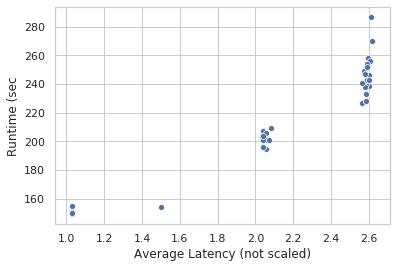

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
ax = plt.figure().subplots()
sns.scatterplot(y='runtime',x='avg_latency',data=milc_runs)#[(milc_runs['avg_latency']>1.7)&(milc_runs['avg_latency']<1.8)],ax=ax)
ax.set_xlabel('Average Latency (not scaled)')
ax.set_ylabel('Runtime (sec')

In [107]:
milc_runs

,start,end,nodelist,runtime,avg_latency,chassis_latency_delay
0,1580571422,1580571676,"nid000[35-36,94-95]",254,2.593674,1.013169
1,1580568866,1580569093,"nid000[35-36,94-95]",227,2.565168,1.013950
2,1580571150,1580571420,"nid000[35-36,94-95]",270,2.618248,1.011335
3,1580568160,1580568399,"nid000[35-36,94-95]",239,2.601642,1.012800
4,1580571491,1580571686,"nid000[37-38,96-97]",195,2.054704,1.022974
5,1580566887,1580567131,"nid000[35-36,94-95]",244,2.594884,1.012401
6,1580566201,1580566441,"nid000[35-36,94-95]",240,2.586334,1.011760
7,1580566629,1580566857,"nid000[35-36,94-95]",228,2.585095,1.013239
8,1580568401,1580568634,"nid000[35-36,94-95]",233,2.583786,1.012936
9,1580568636,1580568864,"nid000[35-36,94-95]",228,2.581847,1.014023
